# Predictiong Hunger as a Binary Classification
* Converted hunger scores to binary variables, using > 2 as the threshold for critically food insecure
* Applied several models with a wide grid search to 3-month predictions
    * Support Vector Classifiers with linear, polynomial, and rbf kernels
    * Naive Bayes with a Gaussian distribution
    * Random Forest Classifier
    * Adaboost Classifier
    * K-Nearest Neighbors
* __Naive Bayes__ was the best performing model by a considerable margin.
* 1-month predictions by Naive Bayes were also promising though not as much as for the 3-month predictions
* More features, better feature engineering, more sophisticated imputation for missing values, and inclusion of the lagged outcome in the feature space are all methods thay may improve upon the current model

In [3]:
import pandas as pd
import pipeline
import importlib
import numpy as np
import matplotlib.pyplot as plt

In [95]:
from sklearn.model_selection import train_test_split, GridSearchCV, GroupKFold, cross_validate
from sklearn.metrics import accuracy_score, precision_score, recall_score, \
                            plot_confusion_matrix, make_scorer, plot_roc_curve, \
                            plot_precision_recall_curve
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

In [31]:
import warnings
warnings.filterwarnings(action='ignore')

In [71]:
# for reloading the pipeline if neccesary...
importlib.reload(pipeline)

<module 'pipeline' from '/Users/matthewmauer/ML/project/pipeline.py'>

## 1 Load and Clean Data
* load and drop redundant columns
* NaNs of event data should be converted to 0s
* event data convert to log scale to reduce skew
* make Admin1 names unique
* look at statistics for features and the hunger score

In [17]:
data = pipeline.read('create_targets/total_data_with_targets.csv')
data.sample(5)

There are 14068 rows and 24 columns in the data set.


,ADMIN0,ADMIN1,month,year,CS,tmin_mm,tmax_mm,tavg_mm,prcp_mm,battle_cnt,...,battle_fatal,protest_fatal,riot_fatal,explosion_fatal,violence_on_civs_fatal,Retail,pop,CS_in_1_month,CS_in_2_months,CS_in_3_months
5984,Somalia,Bay,1.0,2016.0,NaN,NaN,NaN,NaN,NaN,10.0,...,47.0,0.0,0.0,2.0,1.0,-1.098685,NaN,1.5,NaN,NaN
9037,Sudan,Blue Nile,5.0,2016.0,NaN,NaN,NaN,NaN,NaN,1.0,...,3.0,0.0,0.0,2.0,3.0,0.344121,1047000.0,2.0,NaN,NaN
5058,Kenya,Uasin Gishu,10.0,2009.0,1.5,NaN,NaN,NaN,NaN,0.0,...,0.0,0.0,0.0,0.0,1.0,NaN,894179.0,NaN,NaN,2.0
8728,South Sudan,Western Bahr el Ghazal,6.0,2011.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,422000.0,2.0,NaN,NaN
1837,Kenya,Garissa,10.0,2018.0,1.0,NaN,NaN,NaN,NaN,1.0,...,4.0,0.0,0.0,0.0,0.0,NaN,623060.0,NaN,NaN,NaN


In [18]:
data = pipeline.clean_events(data)

In [19]:
data = pipeline.unique_regions(data)

## View Statistics

In [20]:
features = ['tmin_mm', 'tmax_mm', 'tavg_mm', 'prcp_mm',
       'battle_cnt', 'protest_cnt', 'riot_cnt', 'explosion_cnt',
       'violence_on_civs_cnt', 'battle_fatal', 'protest_fatal',
       'riot_fatal', 'explosion_fatal', 'violence_on_civs_fatal',
       'Retail', 'pop']

data[features].describe()

,tmin_mm,tmax_mm,tavg_mm,prcp_mm,battle_cnt,protest_cnt,riot_cnt,explosion_cnt,violence_on_civs_cnt,battle_fatal,protest_fatal,riot_fatal,explosion_fatal,violence_on_civs_fatal,Retail,pop
count,3308.000000,3051.000000,3786.000000,2355.000000,14068.000000,14068.000000,14068.000000,14068.000000,14068.000000,14068.000000,14068.000000,14068.000000,14068.000000,14068.000000,4661.000000,7.895000e+03
mean,194.006999,324.045806,259.036633,75.495813,0.403487,0.217546,0.127565,0.164981,0.382583,0.556682,0.015135,0.048254,0.158233,0.378231,0.642517,2.708599e+06
std,48.576061,50.874524,47.393798,119.916669,0.747403,0.476890,0.347086,0.502241,0.654209,1.171873,0.175835,0.263668,0.607038,0.821119,1.419446,5.611861e+06
min,54.950000,200.000000,143.200000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-3.445507,1.015390e+05
25%,153.174020,287.136646,226.445968,14.250000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.201266,7.439460e+05
50%,197.124060,317.000000,261.696154,43.285714,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.474682,1.098584e+06
75%,234.937500,360.302778,291.386966,85.085965,0.693147,0.000000,0.000000,0.000000,0.693147,0.000000,0.000000,0.000000,0.000000,0.000000,1.312802,1.994000e+06
max,329.100000,464.833333,389.000000,2009.000000,4.043051,5.513429,3.401197,3.850148,3.931826,6.895683,5.241747,5.323010,6.437752,8.074960,7.108684,3.748900e+07


In [21]:
data.CS.dropna().map(lambda x: int(x>2)).describe()

count    4312.000000
mean        0.237245
std         0.425443
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         1.000000
Name: CS, dtype: float64

We see that out of 4312 hunger scores, a little less than a quarter qualify as critical by this crude heuristic.

## 3-month Predictions
* Naive Bayes (Gaussian)
* Support Vector Classifier (linear, polynomial, and rbf kernels)
* Random Forest
* Adaboost

In [25]:
Xtrain, Xtest, Ytrain, Ytest, groups = pipeline.five_way_split(data,
                                                       year=2018,
                                                       features=features,
                                                       target='CS_in_3_months',
                                                       grouping='ADMIN1',
                                                       binary=True,
                                                       binary_threshold=2)

### Support Vector Classifier (SVC)

In [61]:
svc_pipe = Pipeline([
    ('impute', SimpleImputer(strategy='median')),
    ('scale', StandardScaler()),
    ('svc', SVC())
])

params = {
    'svc__kernel': ('linear', 'poly', 'rbf'),
    'svc__C': (0.1, 1, 10),
    'svc__degree': (2,)
} 

scores = {
          'accuracy': make_scorer(accuracy_score),
          'precision': make_scorer(precision_score),
          'recall': make_scorer(recall_score)
         }

gcv = GroupKFold()

svc_grid_model = GridSearchCV(estimator=svc_pipe, 
                          param_grid=params, 
                          cv=gcv,
                          return_train_score=True,
                          scoring=scores,
                          refit='accuracy')

svc_grid_results = svc_grid_model.fit(Xtrain, Ytrain, groups=groups)

In [62]:
pd.DataFrame(svc_grid_results.cv_results_)[['param_svc__kernel', 'param_svc__C', 
            'mean_test_accuracy', 'mean_test_precision', 'mean_test_recall']]

,param_svc__kernel,param_svc__C,mean_test_accuracy,mean_test_precision,mean_test_recall
0,linear,0.1,0.760501,0.000000,0.000000
1,poly,0.1,0.767162,0.606649,0.084096
2,rbf,0.1,0.760210,0.200000,0.001020
3,linear,1,0.760501,0.100000,0.010294
4,poly,1,0.771226,0.600476,0.145133
5,rbf,1,0.774451,0.621268,0.206847
6,linear,10,0.760501,0.100000,0.010294
7,poly,10,0.762808,0.509952,0.180044
8,rbf,10,0.759630,0.502162,0.248133


Accuracy:	0.6620498614958449
Precision:	0.6162790697674418
Recall:		0.3732394366197183
F1 Score:	0.46491228070175444



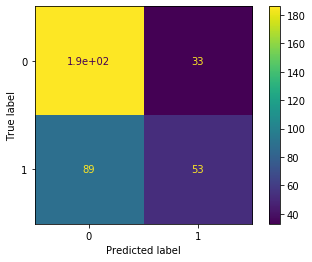

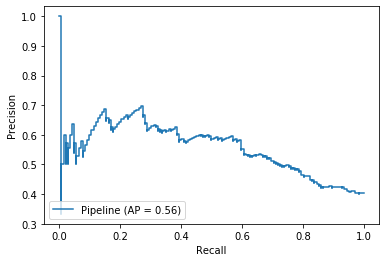

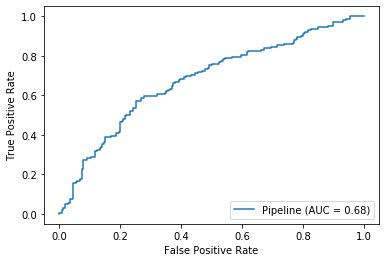

In [75]:
best_svc = svc_grid_results.best_estimator_
pipeline.model_eval(best_svc, Xtest, Ytest, model_type='classification')

#### Results - SVC
The rbf SVC where C=1 appears to perform best. This is a isgnificant improvement on the support vector regression results that provided almost no predictive value. It is possible that by simplifying the prediction problem to a binary classification, our non-linear model is better able to extract patterns in the data and identify correctly those extreme case of food insecurity or case of complete food security.

### Naive Bayes

In [46]:
naive_pipe = Pipeline([
    ('impute', SimpleImputer(strategy='median')),
    ('scale', StandardScaler()),
    ('naive', GaussianNB())
])

cv_results = cross_validate(naive_pipe,
                            Xtrain,
                            Ytrain,
                            cv=gcv,
                            scoring=scores,
                            groups=groups
                            )

In [48]:
pd.DataFrame(cv_results)

,fit_time,score_time,test_accuracy,test_precision,test_recall
0,0.012430,0.004497,0.820290,0.479339,0.487395
1,0.013563,0.004125,0.740580,0.546448,0.510204
2,0.016129,0.003493,0.679710,0.402516,0.336842
3,0.007806,0.003425,0.695461,0.439614,0.497268
4,0.007622,0.003614,0.787791,0.460938,0.433824


Accuracy:	0.6537396121883656
Precision:	0.5459459459459459
Recall:		0.7112676056338029
F1 Score:	0.617737003058104



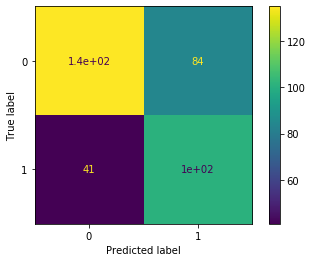

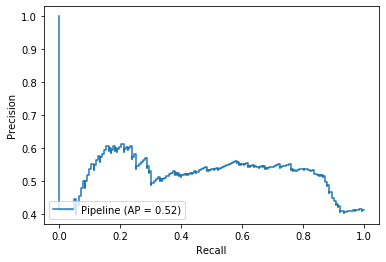

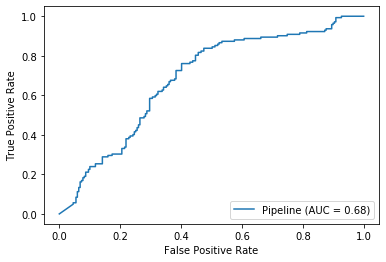

In [74]:
naive_model = naive_pipe.fit(Xtrain, Ytrain)
pipeline.model_eval(naive_model, Xtest, Ytest, model_type='classification')

#### Results - Naive Bayes
The high recall on the Naive Bayes model shows some promise even if the overall accuracy isn't very high. It's more important that our model discover those regions that will most need nutritional assistance in the future than that it never overestimates food insecurity for some regions.  
Overall performance, the Naive Bayes model appears to do a better job than the best performing support vector machine.

### Random Forests

In [58]:
forest_pipe = Pipeline([
    ('impute', SimpleImputer(strategy='median')),
    ('forest', RandomForestClassifier(random_state=30254))
])

params = {
    'forest__criterion': ('gini', 'entropy'),
    'forest__max_depth': (1, 3, 10), 
    'forest__n_estimators': (1, 10, 100)
}

forest_grid_model = GridSearchCV(estimator=forest_pipe, 
                          param_grid=params, 
                          cv=gcv,
                          return_train_score=True,
                          scoring=scores,
                          refit='accuracy')

forest_grid_results = forest_grid_model.fit(Xtrain, Ytrain, groups=groups)

In [60]:
pd.DataFrame(forest_grid_results.cv_results_)[['param_forest__max_depth', 
                                               'param_forest__criterion',
                                               'param_forest__n_estimators',
                                               'mean_test_accuracy', 'mean_test_precision', 
                                               'mean_test_recall']]

,param_forest__max_depth,param_forest__criterion,param_forest__n_estimators,mean_test_accuracy,mean_test_precision,mean_test_recall
0,1,gini,1,0.760501,0.000000,0.000000
1,1,gini,10,0.760501,0.000000,0.000000
2,1,gini,100,0.760501,0.000000,0.000000
3,3,gini,1,0.763418,0.359772,0.048324
4,3,gini,10,0.762527,0.573593,0.049050
5,3,gini,100,0.765433,0.678244,0.047365
6,10,gini,1,0.736426,0.454974,0.318718
7,10,gini,10,0.774722,0.568478,0.255053
8,10,gini,100,0.773563,0.578215,0.258290
9,1,entropy,1,0.760501,0.000000,0.000000


Accuracy:	0.6759002770083102
Precision:	0.654320987654321
Recall:		0.3732394366197183
F1 Score:	0.4753363228699552



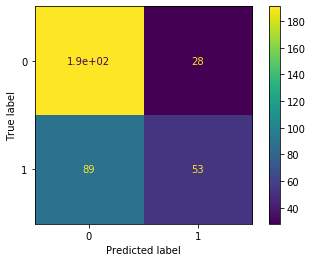

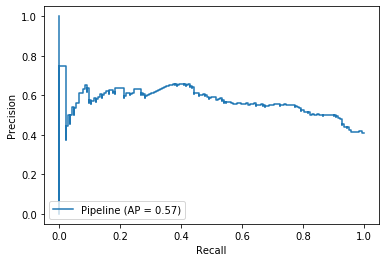

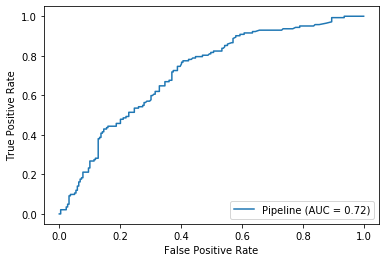

In [73]:
best_forest = forest_grid_results.best_estimator_
pipeline.model_eval(best_forest, Xtest, Ytest, model_type='classification')

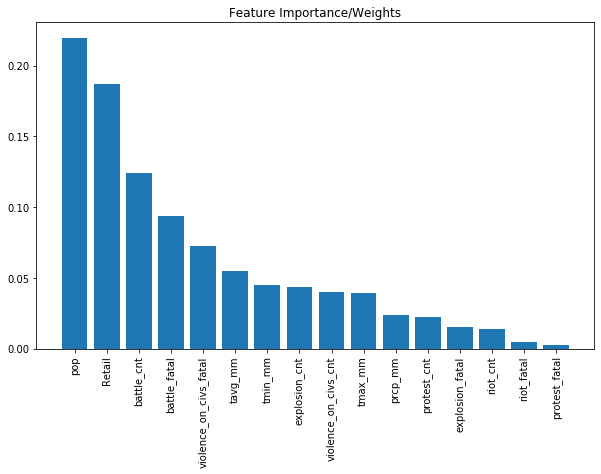

In [70]:
pipeline.feature_importance(best_forest['forest'],
                            labels=Xtrain.columns.values,
                            type='tree')

#### Results - Random Forest
The random forest show modest improvement upon the Naive Bayes model in both precision and overall accuracy; however, the recall of the forest model is defficient when compared to the results of the Naive Bayes model. Considering that we prefer to favor recall in this context, we would advise using the Naive Bayes model over this alternative.  
  
Interestingly, while the random forest regressor only used the number of battle events in a region to make predictions, this random forest classifier, makes use of all the features for its predictions.

### Adaboost

In [68]:
boost_pipe = Pipeline([
    ('impute', SimpleImputer(strategy='median')),
    ('boost', AdaBoostClassifier(random_state=30254))
])

params = {
    'boost__n_estimators': (10, 50, 100),
    'boost__learning_rate': (0.1, 1, 10)
}

boost_grid_model = GridSearchCV(estimator=boost_pipe, 
                          param_grid=params, 
                          cv=gcv,
                          return_train_score=True,
                          scoring=scores,
                          refit='accuracy')

boost_grid_results = boost_grid_model.fit(Xtrain, Ytrain, groups=groups)

In [69]:
pd.DataFrame(boost_grid_results.cv_results_)[['param_boost__n_estimators',
                                              'param_boost__learning_rate',
                                              'mean_test_accuracy', 'mean_test_precision',
                                              'mean_test_recall']]

,param_boost__n_estimators,param_boost__learning_rate,mean_test_accuracy,mean_test_precision,mean_test_recall
0,10,0.1,0.760501,0.000000,0.000000
1,50,0.1,0.765119,0.655830,0.050150
2,100,0.1,0.758171,0.553303,0.156564
3,10,1,0.756692,0.528625,0.288203
4,50,1,0.766621,0.550183,0.302086
5,100,1,0.768378,0.551763,0.323903
6,10,10,0.239499,0.239499,1.000000
7,50,10,0.239499,0.239499,1.000000
8,100,10,0.239499,0.239499,1.000000


Accuracy:	0.667590027700831
Precision:	0.5982142857142857
Recall:		0.47183098591549294
F1 Score:	0.5275590551181103



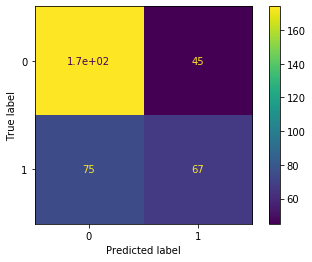

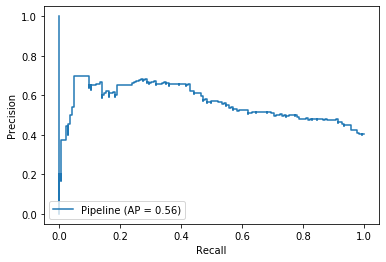

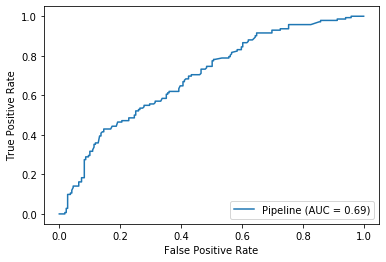

In [72]:
best_boost = boost_grid_results.best_estimator_
pipeline.model_eval(best_boost, Xtest, Ytest, model_type='classification')

#### Results - Adaboost
The performance of our Adaboost model was similar to that of the random forest. However, the ADaboost performance appeared to favor recall somewhat over precision when compare to the random forest. Nonetheless, the results of the Adaboost are inferior to the Naive Bayes model above.

### K-Neighbors

In [101]:
knn_pipe = Pipeline([
    ('impute', SimpleImputer(strategy='median')),
    ('scale', StandardScaler()),
    ('knn', KNeighborsClassifier())
])

params = {
    'knn__n_neighbors': (3, 5, 10, 30),
    'knn__weights': ('uniform', 'distance'),
    'knn__metric': ('euclidean', 'manhattan')
}

knn_grid_model = GridSearchCV(estimator=knn_pipe, 
                          param_grid=params, 
                          cv=gcv,
                          return_train_score=True,
                          scoring=scores,
                          refit='accuracy')

knn_grid_results = knn_grid_model.fit(Xtrain, Ytrain, groups=groups)

In [102]:
pd.DataFrame(knn_grid_results.cv_results_)[['param_knn__n_neighbors',
                                              'param_knn__weights', 'param_knn__metric',
                                              'mean_test_accuracy', 'mean_test_precision',
                                              'mean_test_recall']]

,param_knn__n_neighbors,param_knn__weights,param_knn__metric,mean_test_accuracy,mean_test_precision,mean_test_recall
0,3,uniform,euclidean,0.668546,0.367459,0.443144
1,3,distance,euclidean,0.674628,0.366275,0.439938
2,5,uniform,euclidean,0.721914,0.422788,0.381030
3,5,distance,euclidean,0.718710,0.414766,0.378435
4,10,uniform,euclidean,0.740468,0.460819,0.299951
5,10,distance,euclidean,0.732349,0.445724,0.383243
6,30,uniform,euclidean,0.757605,0.507167,0.223815
7,30,distance,euclidean,0.745986,0.475587,0.322412
8,3,uniform,manhattan,0.669100,0.366477,0.453513
9,3,distance,manhattan,0.675769,0.367250,0.451102


In [104]:
best_knn = knn_grid_results.best_estimator_
best_knn['knn'].get_params()

{'algorithm': 'auto',
 'leaf_size': 30,
 'metric': 'manhattan',
 'metric_params': None,
 'n_jobs': None,
 'n_neighbors': 30,
 'p': 2,
 'weights': 'uniform'}

Accuracy:	0.6537396121883656
Precision:	0.5934065934065934
Recall:		0.38028169014084506
F1 Score:	0.463519313304721



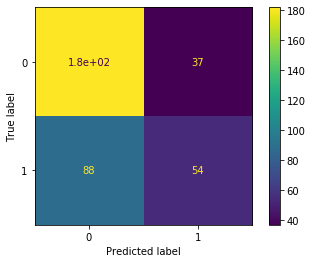

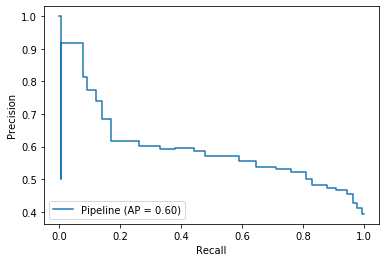

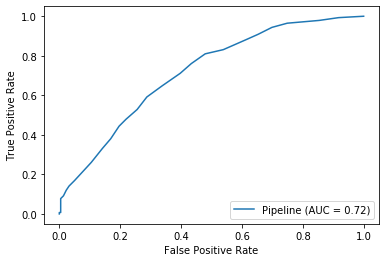

In [103]:
pipeline.model_eval(best_knn, Xtest, Ytest, model_type='classification')

#### Results - KNN
The best performing KNN used manhattan distance weighted uniformly and a rather large number of neighbors — 30. All versions of this model had comparitively low recall, so we do not advise future use.

## 1-month Predictions with Naive Bayes

In [93]:
Xtrain1, Xtest1, Ytrain1, Ytest1, groups1 = pipeline.five_way_split(data,
                                                       year=2018,
                                                       features=features,
                                                       target='CS_in_1_month',
                                                       grouping='ADMIN1',
                                                       binary=True,
                                                       binary_threshold=2)

cv_results1 = cross_validate(naive_pipe,
                            Xtrain1,
                            Ytrain1,
                            cv=gcv,
                            scoring=scores,
                            groups=groups1
                            )

pd.DataFrame(cv_results1)

,fit_time,score_time,test_accuracy,test_precision,test_recall
0,0.007273,0.003706,0.580931,0.439024,0.818182
1,0.006586,0.003985,0.577778,0.416667,0.798611
2,0.006631,0.004086,0.580000,0.446494,0.756250
3,0.006657,0.003610,0.528889,0.253731,0.850000
4,0.014212,0.006270,0.360000,0.268293,0.846154


Accuracy:	0.566079295154185
Precision:	0.4634920634920635
Recall:		0.8390804597701149
F1 Score:	0.5971370143149284



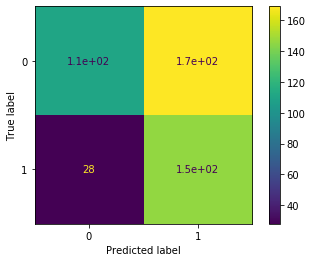

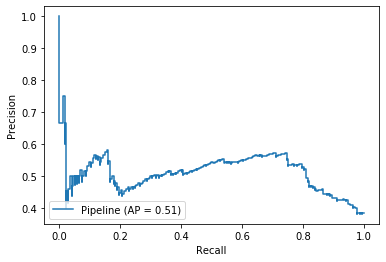

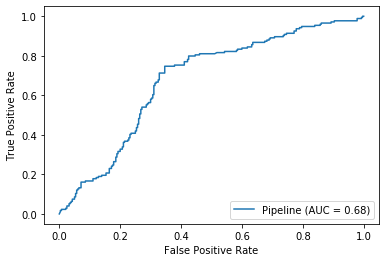

In [106]:
naive_pipe.fit(Xtrain1, Ytrain1)
pipeline.model_eval(naive_pipe, Xtest1, Ytest1, model_type='classification')

## 2-month Predictions with Naive Bayes

In [105]:
Xtrain2, Xtest2, Ytrain2, Ytest2, groups2 = pipeline.five_way_split(data,
                                                       year=2018,
                                                       features=features,
                                                       target='CS_in_2_months',
                                                       grouping='ADMIN1',
                                                       binary=True,
                                                       binary_threshold=2)

cv_results2 = cross_validate(naive_pipe,
                            Xtrain2,
                            Ytrain2,
                            cv=gcv,
                            scoring=scores,
                            groups=groups2
                            )

pd.DataFrame(cv_results2)

,fit_time,score_time,test_accuracy,test_precision,test_recall
0,0.008751,0.005586,0.682119,0.454106,0.752000
1,0.007182,0.004291,0.632743,0.440741,0.888060
2,0.007249,0.004223,0.547461,0.401544,0.675325
3,0.006579,0.004065,0.596026,0.392857,0.767442
4,0.010848,0.006102,0.632743,0.423729,0.539568


Accuracy:	0.5577889447236181
Precision:	0.44866920152091255
Recall:		0.7919463087248322
F1 Score:	0.5728155339805825



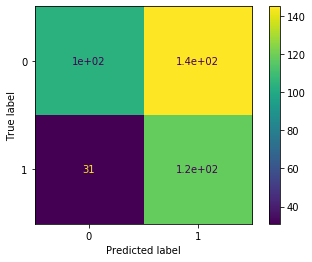

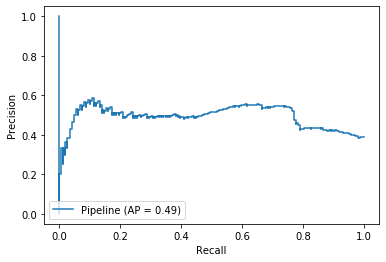

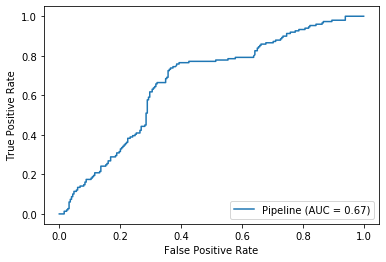

In [107]:
naive_pipe.fit(Xtrain2, Ytrain2)
pipeline.model_eval(naive_pipe, Xtest2, Ytest2, model_type='classification')

## Results
The low precision and high recall of our Naive Bayes results are a consistent theme. Considering that for our context recall is the priority, the Naive Bayes model provides some value added for identifying food insecure regions with considerable lead time. More features, better feature engineering, more sophisticated imputation for missing values, and inclusion of the lagged outcome in the feature space are all methods thay may improve upon the current model.